# Problem Statement


WHO is a specialized agency of the UN which is concerned with the world population health. Based upon the various parameters, WHO allocates budget for various areas to conduct various campaigns/initiatives to improve healthcare. Annual salary is an important variable which is considered to decide budget to be allocated for an area.  
  
We have a data which contains information about 32561 samples and 15 continuous and categorical variables. Extraction of data was done from 1994 Census dataset.  
  
The goal here is to build a binary model to predict whether the salary is >50K or <50K.

## Data Dictionary

1. <b>age:</b> age  
2. <b>workclass:</b> workclass  
3. <b>education:</b> highest education  
4. <b>marrital status:</b> marital status  
5. <b>occupation:</b> occupation  
6. <b>sex:</b> sex  
7. <b>capital gain:</b> income from investment sources other than salary/wages  
8. <b>capital loss:</b> income from investment sources other than salary/wages  
9. <b>working hours:</b> nummber of working hours per week  
10. <b>salary:</b> salary  

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

In [69]:
adult_data=pd.read_csv("adult_data.csv")

### EDA

In [70]:
adult_data.head()

,age,workclass,education,marrital status,occupation,sex,capital gain,capital loss,working hours per week,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Male,0,0,13,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Male,0,0,40,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Male,0,0,40,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Female,0,0,40,<=50K


In [71]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     32561 non-null  int64 
 1   workclass               32561 non-null  object
 2   education               32561 non-null  object
 3   marrital status         32561 non-null  object
 4   occupation              32561 non-null  object
 5   sex                     32561 non-null  object
 6   capital gain            32561 non-null  int64 
 7   capital loss            32561 non-null  int64 
 8   working hours per week  32561 non-null  int64 
 9   salary                  32561 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.5+ MB


There are no missing values. 6 variables are numeric and remaining categorical. Categorical variables are not in encoded format

### Check for duplicate data

In [73]:
dups = adult_data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(adult_data.shape)

Number of duplicate rows = 5864
(32561, 10)


Do we need to remove the duplicate data over here? We have removed the duplicate data but when are the cases that we remove duplicate data?

In [74]:
adult_data.drop_duplicates(inplace=True) 

In [75]:
dups = adult_data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(adult_data.shape)

Number of duplicate rows = 0
(26697, 10)


### Geting unique counts of all Objects

In [76]:
for feature in adult_data.columns: 
    if adult_data[feature].dtype == 'object': 
        print(feature)
        print(adult_data[feature].value_counts())
        print('\n')
        

workclass
Private             17474
Self-emp-not-inc     2447
Local-gov            1980
?                    1519
State-gov            1246
Self-emp-inc         1089
Federal-gov           921
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


education
HS-grad         7815
Some-college    5692
Bachelors       4461
Masters         1606
Assoc-voc       1281
Assoc-acdm      1036
11th             987
10th             820
7th-8th          611
Prof-school      562
9th              502
Doctorate        399
12th             397
5th-6th          315
1st-4th          164
Preschool         49
Name: education, dtype: int64


marrital status
Married-civ-spouse       12679
Never-married             7698
Divorced                  3930
Separated                  978
Widowed                    971
Married-spouse-absent      418
Married-AF-spouse           23
Name: marrital status, dtype: int64


occupation
Prof-specialty       3703
Exec-managerial      3531
Sales       

'workclass' and 'occupation' has ?  
Since, high number of cases have ?, we will convert them into a new level

In [77]:
# Replace ? to new Unk category
adult_data.workclass=adult_data.workclass.str.replace('?', 'Unk')
adult_data.occupation = adult_data.occupation.str.replace('?', 'Unk')

In [79]:
adult_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,26697.0,39.987489,13.691269,17.0,29.0,39.0,49.0,90.0
capital gain,26697.0,1304.600929,8111.031099,0.0,0.0,0.0,0.0,99999.0
capital loss,26697.0,105.699330,441.214823,0.0,0.0,0.0,0.0,4356.0
working hours per week,26697.0,40.852530,13.114255,1.0,38.0,40.0,46.0,99.0


### Checking the spread of the data using boxplot for the continuous variables.

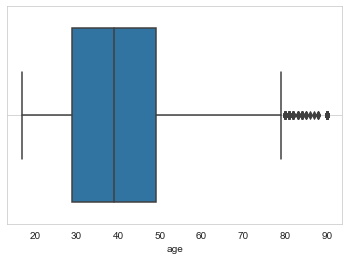

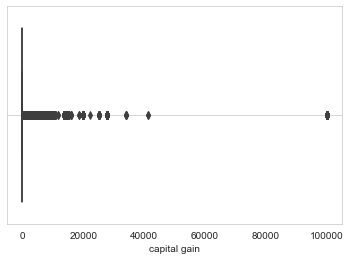

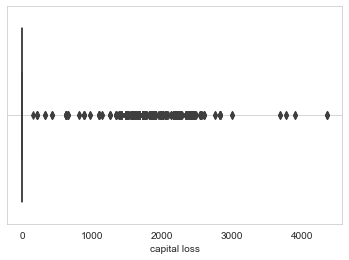

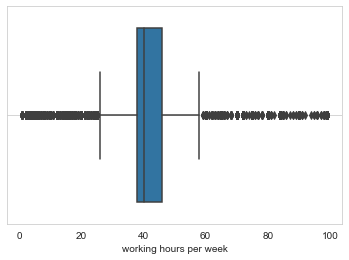

In [80]:
cols = ['age','capital gain','capital loss','working hours per week']
for i in cols:
    sns.boxplot(adult_data[i],whis=1.5)
    plt.grid()
    plt.show();

### Treating the outliers.
###### We can treat Outliers with the following code. We will treat the outliers for the 'Age' variable only.

In [81]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [52]:
## This is a loop to treat outliers for all the non-'object' type varible

for column in adult_data.columns:
    if adult_data[column].dtype != 'object': 
        lr,ur=remove_outlier(adult_data[column])
        print('For column :',column,'Lower Range :',lr,'Upper Range :',ur)
        adult_data[column]=np.where(adult_data[column]>ur,ur,adult_data[column])
        adult_data[column]=np.where(adult_data[column]<lr,lr,adult_data[column])

For column : age Lower Range : -1.0 Upper Range : 79.0
For column : capital gain Lower Range : 0.0 Upper Range : 0.0
For column : capital loss Lower Range : 0.0 Upper Range : 0.0
For column : working hours per week Lower Range : 26.0 Upper Range : 58.0


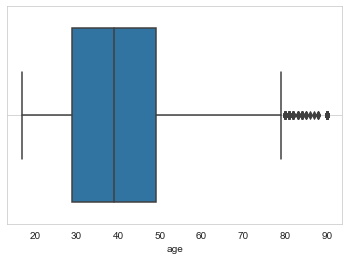

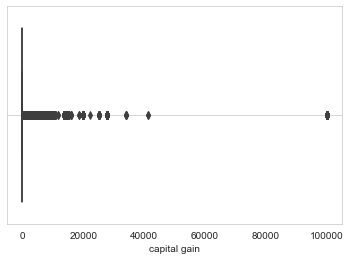

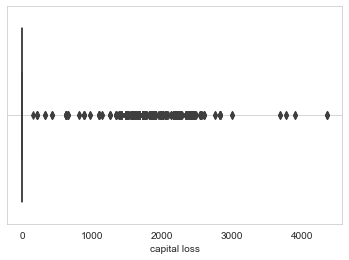

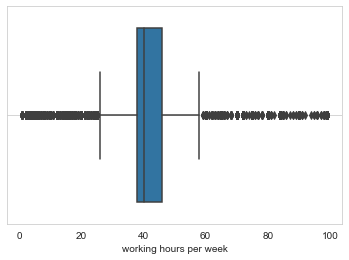

In [82]:
cols = ['age','capital gain','capital loss','working hours per week']
for i in cols:
    sns.boxplot(adult_data[i],whis=1.5)
    plt.grid()
    plt.show();

In [83]:
lr,ur=remove_outlier(adult_data['working hours per week'])
print('Lower Range :',lr,'\nUpper Range :',ur)
adult_data['working hours per week']=np.where(adult_data['working hours per week']>ur,ur,adult_data['working hours per week'])
adult_data['working hours per week']=np.where(adult_data['working hours per week']<lr,lr,adult_data['working hours per week'])

Lower Range : 26.0 
Upper Range : 58.0


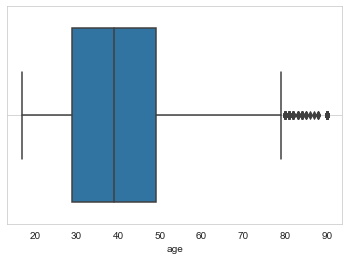

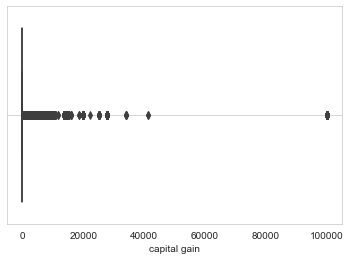

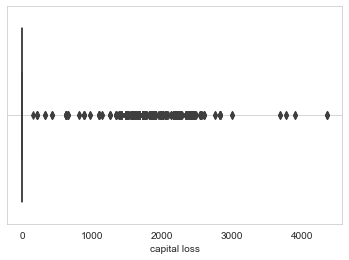

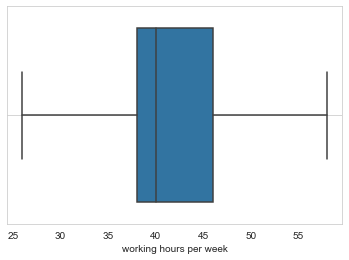

In [84]:
cols = ['age','capital gain','capital loss','working hours per week']
for i in cols:
    sns.boxplot(adult_data[i],whis=1.5)
    plt.grid()
    plt.show();

### Checking for Correlations.

In [85]:
adult_data.corr()

,age,capital gain,capital loss,working hours per week
age,1.000000,0.068974,0.039005,0.037001
capital gain,0.068974,1.000000,-0.038534,0.085196
capital loss,0.039005,-0.038534,1.000000,0.055047
working hours per week,0.037001,0.085196,0.055047,1.000000


In [18]:
np.triu(adult_data.corr(),+1)

array([[ 0.        ,  0.06897416,  0.03900493,  0.03700075],
       [ 0.        ,  0.        , -0.03853364,  0.08519643],
       [ 0.        ,  0.        ,  0.        ,  0.05504727],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

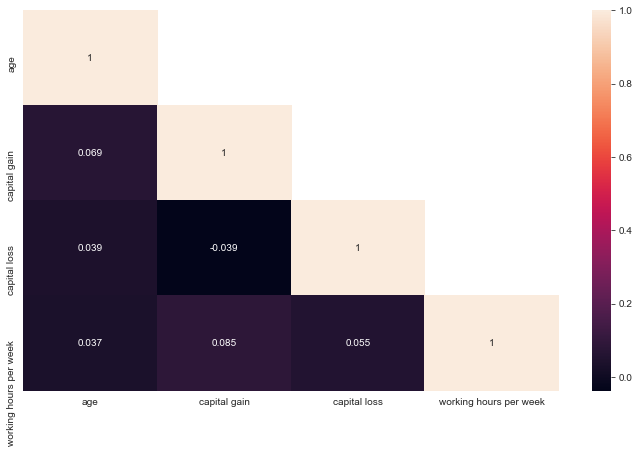

In [86]:
plt.figure(figsize=(12,7))
sns.heatmap(adult_data.corr(), annot=True,mask=np.triu(adult_data.corr(),+1));

In [87]:
adult_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,26697.0,39.987489,13.691269,17.0,29.0,39.0,49.0,90.0
capital gain,26697.0,1304.600929,8111.031099,0.0,0.0,0.0,0.0,99999.0
capital loss,26697.0,105.699330,441.214823,0.0,0.0,0.0,0.0,4356.0
working hours per week,26697.0,41.169682,9.029725,26.0,38.0,40.0,46.0,58.0


There is hardly any correlation between the numeric variables

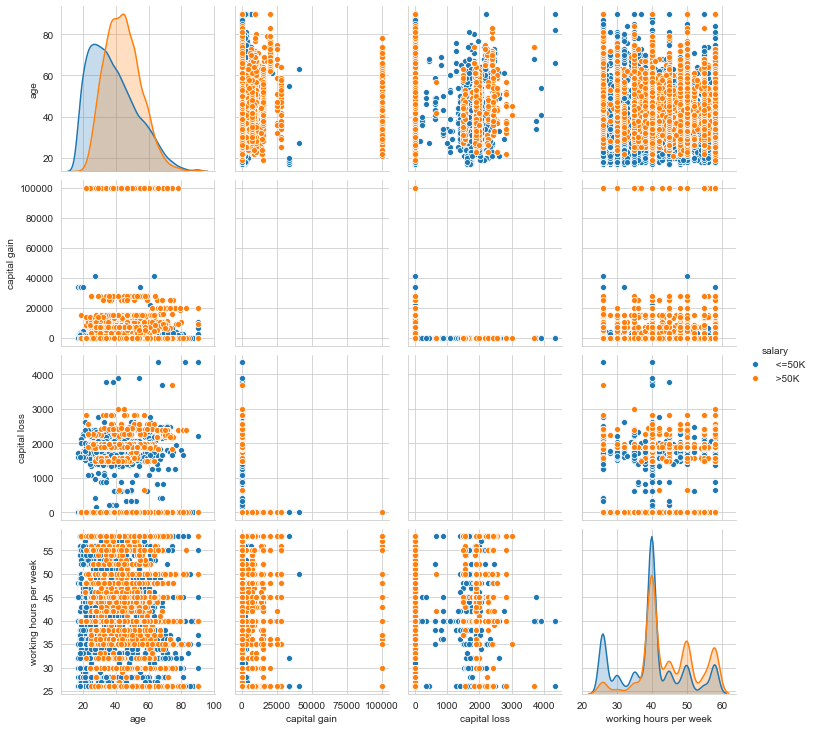

In [88]:
# Pairplot using sns
sns.pairplot(adult_data ,diag_kind='kde' ,hue='salary');

In [89]:
num_cols = adult_data.select_dtypes(exclude=['object','category']).columns
cat_cols = adult_data.select_dtypes(include=['object','category']).columns

In [90]:
num_cols

Index(['age', 'capital gain', 'capital loss', 'working hours per week'], dtype='object')

In [91]:
cat_cols

Index(['workclass', 'education', 'marrital status', 'occupation', 'sex',
       'salary'],
      dtype='object')

In [92]:
import warnings
warnings.filterwarnings("ignore")

In [93]:
cat_cols = ['workclass', 'education', 'marrital status', 'occupation', 'sex']
def plot_count(df,colnames,col_x,row=1,col=2):
    i=1
    sns.set_style("whitegrid")
    for colname in colnames:
        ax=fig.add_subplot(row,col,i)
        i=i+1
        sns.countplot(colname, data = df, hue = col_x,palette = 'pastel')
        ax.set_title(colname,color='Blue',fontsize = 14)
        plt.xticks(rotation=45)
        for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                if (p.get_height() >0):
                    value = int(p.get_height())
                    ax.text(_x, _y, value, ha="center") 
        plt.grid()
    plt.tight_layout()

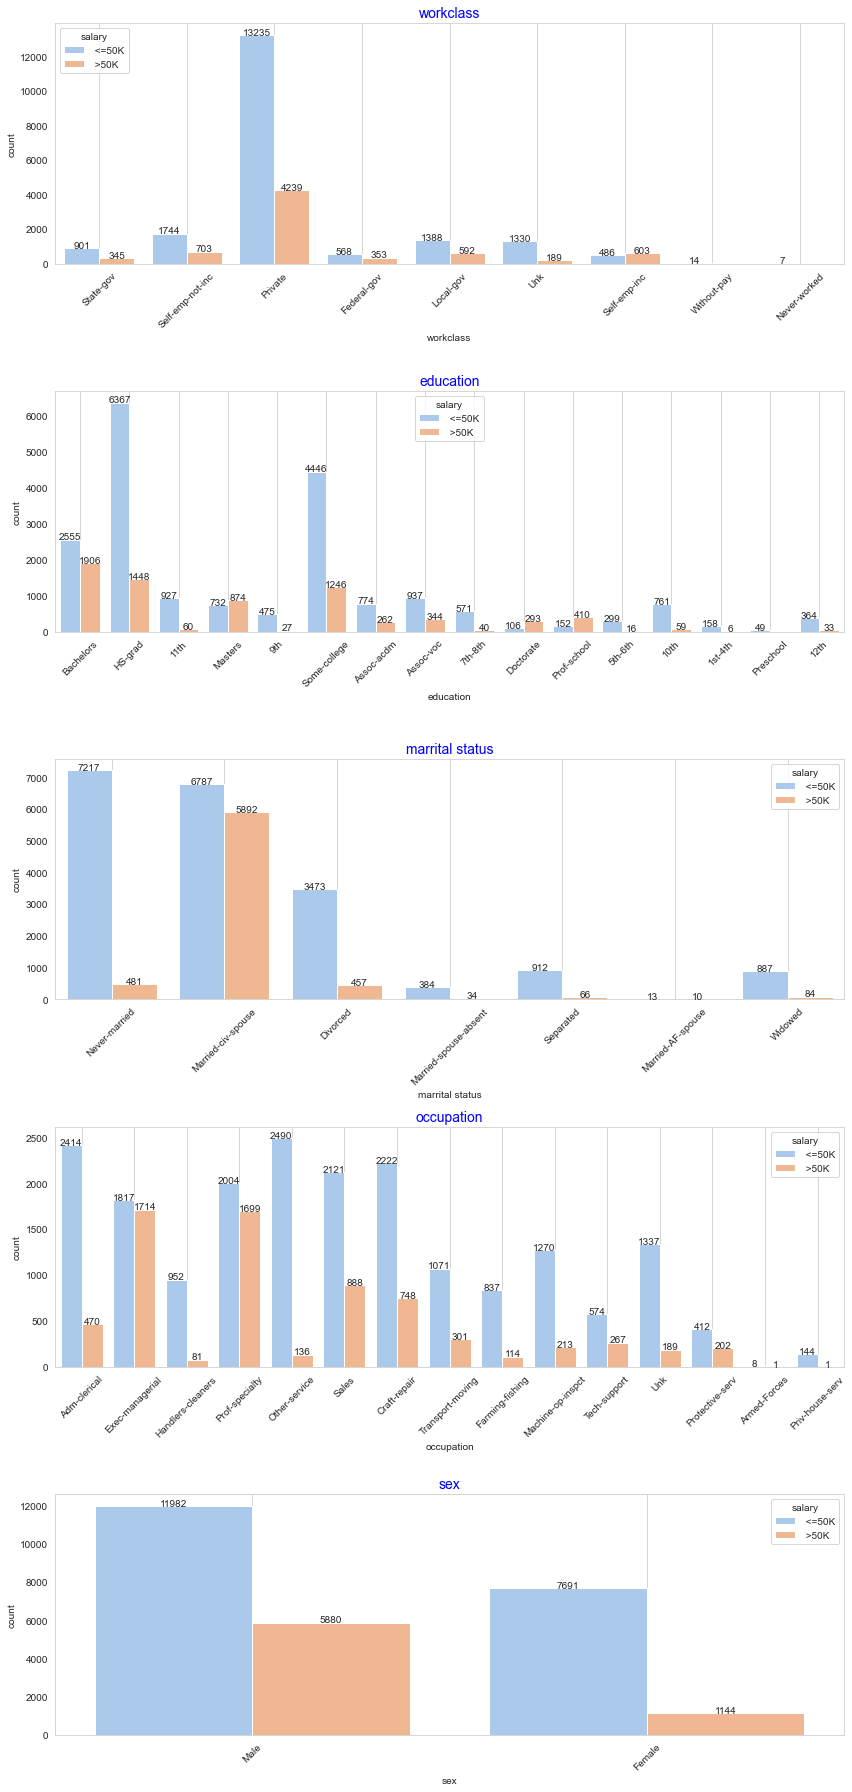

In [94]:
fig=plt.figure(figsize=(12,25))
plot_count(adult_data,cat_cols,'salary',5,1);

### Converting all objects to categorical codes

In [95]:
## We are coding up the 'education' variable in an ordinal manner

adult_data['education']=np.where(adult_data['education'] =='Preschool', '1', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='1st-4th', '2', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='5th-6th', '3', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='7th-8th', '4', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='9th', '5', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='10th', '6', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='11th', '7', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='12th', '8', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='HS-grad', '9', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Prof-school', '9', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Assoc-acdm', '10', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Assoc-voc', '11', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Some-college', '12', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Bachelors', '13', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Masters', '14', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Doctorate', '15', adult_data['education'])

In [96]:
## We are grouping certain types of 'workclass' under different categories

adult_data['workclass']=np.where(adult_data['workclass'] =='Federal-gov', 'Government', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Local-gov', 'Government', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='State-gov', 'Government', adult_data['workclass'])

adult_data['workclass']=np.where(adult_data['workclass'] =='Self-emp-inc', 'Others', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Self-emp-not-inc', 'Others', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='unknown', 'Others', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Without-pay', 'Others', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Never-worked', 'Others', adult_data['workclass'])

In [97]:
## We are grouping certain types of 'marritalstatus' under different categories

adult_data['marrital status']=np.where(adult_data['marrital status'] =='Divorced', 'CurrentlySingle', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Separated', 'CurrentlySingle', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Never-married', 'CurrentlySingle', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Widowed', 'CurrentlySingle', adult_data['marrital status'])

adult_data['marrital status']=np.where(adult_data['marrital status'] =='Married-civ-spouse', 'Married', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Married-spouse-absent', 'Married', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Married-AF-absent', 'Married', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Married-AF-spouse', 'Married', adult_data['marrital status'])

In [98]:
## We are grouping certain types of 'occupation' under different categories

adult_data['occupation']=np.where(adult_data['occupation'] =='Adm-clerical', 'WhiteCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Exec-managerial', 'WhiteCollar', adult_data['occupation'])

adult_data['occupation']=np.where(adult_data['occupation'] =='Craft-repair', 'BlueCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Handlers-cleaners', 'BlueCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Transport-moving', 'BlueCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Farming-fishing', 'BlueCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Machine-op-inspct', 'BlueCollar', adult_data['occupation'])

adult_data['occupation']=np.where(adult_data['occupation'] =='Tech-support', 'Service', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Other-service', 'Service', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Protective-serv', 'Service', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Priv-house-serv', 'Service', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Prof-specialty', 'Service', adult_data['occupation'])

adult_data['occupation']=np.where(adult_data['occupation'] =='unknown', 'Unknown_Others', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Armed-Forces', 'Unknown_Others', adult_data['occupation'])

In [99]:
adult_data.head()

,age,workclass,education,marrital status,occupation,sex,capital gain,capital loss,working hours per week,salary
0,39,Government,13,CurrentlySingle,WhiteCollar,Male,2174,0,40.0,<=50K
1,50,Others,13,Married,WhiteCollar,Male,0,0,26.0,<=50K
2,38,Private,9,CurrentlySingle,BlueCollar,Male,0,0,40.0,<=50K
3,53,Private,7,Married,BlueCollar,Male,0,0,40.0,<=50K
4,28,Private,13,Married,Service,Female,0,0,40.0,<=50K


In [100]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26697 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     26697 non-null  int64  
 1   workclass               26697 non-null  object 
 2   education               26697 non-null  object 
 3   marrital status         26697 non-null  object 
 4   occupation              26697 non-null  object 
 5   sex                     26697 non-null  object 
 6   capital gain            26697 non-null  int64  
 7   capital loss            26697 non-null  int64  
 8   working hours per week  26697 non-null  float64
 9   salary                  26697 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 3.5+ MB


In [101]:
## Converting the education variable to numeric

adult_data['education'] = adult_data['education'].astype('int64')
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26697 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     26697 non-null  int64  
 1   workclass               26697 non-null  object 
 2   education               26697 non-null  int64  
 3   marrital status         26697 non-null  object 
 4   occupation              26697 non-null  object 
 5   sex                     26697 non-null  object 
 6   capital gain            26697 non-null  int64  
 7   capital loss            26697 non-null  int64  
 8   working hours per week  26697 non-null  float64
 9   salary                  26697 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 3.5+ MB


In [102]:
## Converting the 'salary' Variable into numeric by using the LabelEncoder functionality inside sklearn.
from sklearn.preprocessing import LabelEncoder

## Defining a Label Encoder object instance
LE = LabelEncoder()

In [103]:
## Applying the created Label Encoder object for the target class
## Assigning the 0 to <=50k and 1 to >50k

adult_data['salary'] = LE.fit_transform(adult_data['salary'])
adult_data.head()

,age,workclass,education,marrital status,occupation,sex,capital gain,capital loss,working hours per week,salary
0,39,Government,13,CurrentlySingle,WhiteCollar,Male,2174,0,40.0,0
1,50,Others,13,Married,WhiteCollar,Male,0,0,26.0,0
2,38,Private,9,CurrentlySingle,BlueCollar,Male,0,0,40.0,0
3,53,Private,7,Married,BlueCollar,Male,0,0,40.0,0
4,28,Private,13,Married,Service,Female,0,0,40.0,0


In [104]:
## Converting the other 'object' type variables as dummy variables

adult_data_dummy = pd.get_dummies(adult_data,drop_first=True)
adult_data_dummy.head()

,age,education,capital gain,capital loss,working hours per week,salary,workclass_Others,workclass_Private,workclass_Unk,marrital status_Married,occupation_Sales,occupation_Service,occupation_Unk,occupation_Unknown_Others,occupation_WhiteCollar,sex_Male
0,39,13,2174,0,40.0,0,0,0,0,0,0,0,0,0,1,1
1,50,13,0,0,26.0,0,1,0,0,1,0,0,0,0,1,1
2,38,9,0,0,40.0,0,0,1,0,0,0,0,0,0,0,1
3,53,7,0,0,40.0,0,0,1,0,1,0,0,0,0,0,1
4,28,13,0,0,40.0,0,0,1,0,1,0,1,0,0,0,0


In [108]:
adult_data_dummy['salary'].value_counts(normalize=True)

0    0.736899
1    0.263101
Name: salary, dtype: float64

### Train Test Split

In [106]:
# Copy all the predictor variables into X dataframe
X = adult_data_dummy.drop('salary', axis=1)

# Copy target into the y dataframe. 
y = adult_data_dummy['salary']

In [107]:
# Split X and y into training and test set in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1,stratify=adult_data_dummy['salary'])

In [109]:
y_train.value_counts(1)

0    0.736876
1    0.263124
Name: salary, dtype: float64

In [110]:
y_test.value_counts(1)

0    0.736954
1    0.263046
Name: salary, dtype: float64

### Logistic Regression Model

We are making some adjustments to the parameters in the Logistic Regression Class to get a better accuracy. Details of which can be found out on the site scikit-learn mentioned below

<a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>scikit-learn</a>

>Argument=solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem.

>For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

>For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

>‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty

>‘liblinear’ and ‘saga’ also handle L1 penalty

>‘saga’ also supports ‘elasticnet’ penalty

>‘liblinear’ does not support setting penalty='none'

>Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

>New in version 0.17: Stochastic Average Gradient descent solver.

>New in version 0.19: SAGA solver.

>Changed in version 0.22: The default solver changed from ‘liblinear’ to ‘lbfgs’ in 0.22.

<a href='https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451'> Article on Solvers</a>



In [111]:
# Fit the Logistic Regression model
model = LogisticRegression(solver='newton-cg',max_iter=10000,penalty='none',verbose=True,n_jobs=-1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished


LogisticRegression(max_iter=10000, n_jobs=-1, penalty='none',
                   solver='newton-cg', verbose=True)

In [112]:
# Fit the Logistic Regression model
model = LogisticRegression(solver='newton-cg',max_iter=10000,penalty='none',verbose=True,n_jobs=2)
model.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    5.5s finished


LogisticRegression(max_iter=10000, n_jobs=2, penalty='none', solver='newton-cg',
                   verbose=True)

### Predicting on Training and Test dataset

In [113]:
ytrain_predict = model.predict(X_train)
ytest_predict = model.predict(X_test)

In [115]:
ytrain_predict

array([0, 0, 0, ..., 0, 0, 0])

### Getting the Predicted Classes and Probs

In [114]:
ytest_predict_prob=model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.563210,0.436790
1,0.005707,0.994293
2,0.933151,0.066849
3,0.761364,0.238636
4,0.716087,0.283913


## Model Evaluation

In [116]:
# Accuracy - Training Data
model.score(X_train, y_train)

0.8265104083052389

### AUC and ROC for the training data

AUC: 0.881


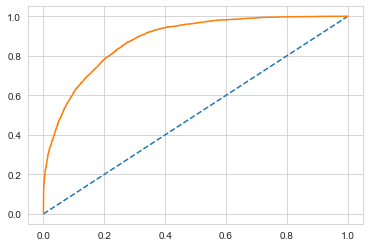

In [117]:
# predict probabilities
probs = model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

In [118]:
# Accuracy - Test Data
model.score(X_test, y_test)

0.8213483146067416

### AUC and ROC for the test data

AUC: 0.881


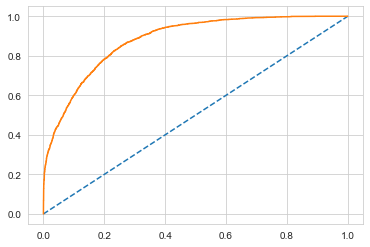

In [119]:
# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

### Confusion Matrix for the training data

In [121]:
tn, fp, fn, tp = confusion_matrix(y_train, ytrain_predict).ravel()
tn, fp, fn, tp

(12674, 1096, 2146, 2771)

In [120]:
confusion_matrix(y_train, ytrain_predict)

array([[12674,  1096],
       [ 2146,  2771]], dtype=int64)

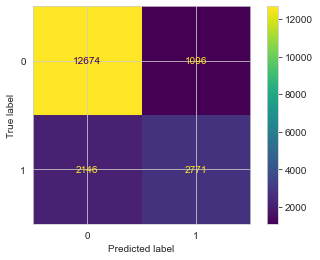

In [122]:
plot_confusion_matrix(model,X_train,y_train);

In [54]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     13770
           1       0.72      0.56      0.63      4917

    accuracy                           0.83     18687
   macro avg       0.79      0.74      0.76     18687
weighted avg       0.82      0.83      0.82     18687



### Confusion Matrix for test data

In [55]:
confusion_matrix(y_test, ytest_predict)

array([[5412,  491],
       [ 940, 1167]], dtype=int64)

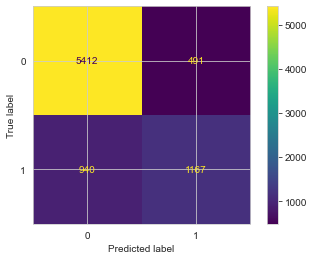

In [56]:
plot_confusion_matrix(model,X_test,y_test);

In [57]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5903
           1       0.70      0.55      0.62      2107

    accuracy                           0.82      8010
   macro avg       0.78      0.74      0.75      8010
weighted avg       0.81      0.82      0.81      8010



## Applying GridSearchCV for Logistic Regression

In [123]:
grid={'penalty':['l2','none'],
      'solver':['sag','lbfgs'],
      'tol':[0.0001,0.00001]}

In [124]:
model = LogisticRegression(max_iter=10000,n_jobs=2)

In [125]:
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 3,n_jobs=-1,scoring='f1')

In [126]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=10000, n_jobs=2),
             n_jobs=-1,
             param_grid={'penalty': ['l2', 'none'], 'solver': ['sag', 'lbfgs'],
                         'tol': [0.0001, 1e-05]},
             scoring='f1')

In [127]:
print(grid_search.best_params_,'\n')
print(grid_search.best_estimator_)

{'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001} 

LogisticRegression(max_iter=10000, n_jobs=2)


In [128]:
best_model = grid_search.best_estimator_

In [129]:
# Prediction on the training set

ytrain_predict = best_model.predict(X_train)
ytest_predict = best_model.predict(X_test)

In [130]:
## Getting the probabilities on the test set

ytest_predict_prob=best_model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.569658,0.430342
1,0.005321,0.994679
2,0.929277,0.070723
3,0.769657,0.230343
4,0.697778,0.302222


              precision    recall  f1-score   support

           0       0.85      0.92      0.89     13770
           1       0.71      0.56      0.63      4917

    accuracy                           0.83     18687
   macro avg       0.78      0.74      0.76     18687
weighted avg       0.82      0.83      0.82     18687
 



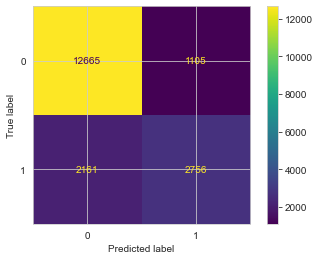

In [131]:
## Confusion matrix on the training data

plot_confusion_matrix(best_model,X_train,y_train)
print(classification_report(y_train, ytrain_predict),'\n');

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5903
           1       0.70      0.55      0.62      2107

    accuracy                           0.82      8010
   macro avg       0.78      0.73      0.75      8010
weighted avg       0.81      0.82      0.81      8010
 



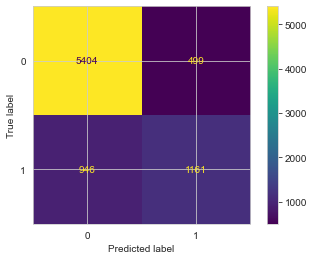

In [132]:
## Confusion matrix on the test data

plot_confusion_matrix(best_model,X_test,y_test)
print(classification_report(y_test, ytest_predict),'\n');

You can select other parameters to perform GridSearchCV and try optimize the desired parameter.

Note: Alternatively, one hot encoding can also be done instead of label encoding on categorical variables before building the logistic regression model. Do play around with these techniques using one hot encoding as well.

# Running in Google Colab
Importing jupyter notebook
1. Login to Google
2. Go to drive.google.com
3. Upload jupyter notebook file into the drive
4. double click it, or right click -&gt; open with -&gt; google colaboratory
Alternatively,
1. Login to Google
2. Go to https://colab.research.google.com/notebooks/intro.ipynb#recent=true
3. Upload the jupyter notebook

Loading dataset into colab
## Use the below code to load the dataset
from google.colab import files

uploaded = files.upload() # upload file here from local

import io

df2 = pd.read_csv(io.BytesIO(uploaded[&#39;Filename.csv&#39;])) #give the filename in quotes

Go to Runtime > change Runtime type > check if it points to Python

In [133]:
best_model.coef_

array([[ 2.55799136e-02,  2.41573480e-01,  3.14058062e-04,
         6.75063562e-04,  4.93429325e-02, -2.16407912e-01,
        -7.81284422e-02, -2.62419729e-01,  2.13218247e+00,
         3.14263053e-01,  5.86817114e-01, -2.90592085e-01,
        -2.58406864e-02,  6.50062618e-01,  2.92394289e-01]])

In [134]:
# Let us explore the coefficients for each of the independent attributes

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, best_model.coef_[0][idx]))

The coefficient for age is 0.02557991356493344
The coefficient for education is 0.24157348048835042
The coefficient for capital gain is 0.0003140580616568482
The coefficient for capital loss is 0.0006750635615553449
The coefficient for working hours per week is 0.04934293246663768
The coefficient for workclass_Others is -0.21640791156666433
The coefficient for workclass_Private is -0.07812844224185767
The coefficient for workclass_Unk is -0.26241972877176084
The coefficient for marrital status_Married is 2.1321824653193784
The coefficient for occupation_Sales is 0.3142630531861867
The coefficient for occupation_Service is 0.5868171135376126
The coefficient for occupation_Unk is -0.29059208504332334
The coefficient for occupation_Unknown_Others is -0.025840686421127627
The coefficient for occupation_WhiteCollar is 0.6500626179905391
The coefficient for sex_Male is 0.2923942889645823


                                                    Happy Learning